<a href="https://colab.research.google.com/github/saharkoohfar/crash-severity-prediction/blob/main/RNN_CNN-CRASH_SEVERITY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from more_itertools import sliced
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, SpatialDropout1D, RNN, SimpleRNN
from keras.layers import Dense, Conv1D, MaxPooling2D, Flatten, LSTM, Dropout, MaxPooling1D
from sklearn.metrics import precision_score, recall_score, f1_score


from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow import keras
import math 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import preprocessing
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.callbacks import TensorBoard
import random

random.seed(12345)

In [ ]:
df = pd.read_csv('Crash_64E.csv')
df=df.sort_values('CRASH_DT')


df.set_index('CRASH_DT', inplace=True)
df.index = pd.to_datetime(df.index)
df.dropna(axis=1)

df['CRASH_SEVE'] = df['CRASH_SEVE'].replace(['K', 'A', 'B', 'O','C'], [3,2,1,0,0])


In [ ]:
from imblearn.over_sampling import RandomOverSampler

Y = df['CRASH_SEVE']
X = df.drop(['CRASH_SEVE'], axis=1)
X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state=42)

X_train, y_train = RandomOverSampler().fit_resample(X_train, y_train)
X_test, y_test = RandomOverSampler().fit_resample(X_test, y_test)



In [ ]:
# building timeseries data with given timesteps (lags)
def timeseries(time_steps):
    try:
      input_size_0 = X_train.shape[0]
      input_size_1 = X_train.shape[1]
      input_size_2 = X_test.shape[0]
      X_trn = np.zeros((input_size_0, time_steps, input_size_1))
      X_tst = np.zeros((input_size_2, time_steps, input_size_1))
      y_trn = np.zeros((input_size_0,))
      y_tst = np.zeros((input_size_2,))
      
      for i in range(input_size_0):
        if time_steps+i < input_size_0:
          X_trn[i] = X_train[i:time_steps+i]
          y_trn[i] = y_train[time_steps+i-1]
          
      for i in range(input_size_2):
        if time_steps+i < input_size_2:
          X_tst[i, :len(X_test[i:time_steps+i])] = X_test[i:time_steps+i]
          y_tst[i] = y_test[time_steps+i-1]

      print("length of time-series i/o",X_trn.shape,y_trn.shape)
      return X_trn,X_tst, y_trn, y_tst
    except KeyError as e:
      print(e)

In [ ]:

import itertools
Layer_list = [1, 3, 6]
Dimention_list = [32, 64, 128]
H_list = [1, 8]
Epoch_list = [100]
List = [Layer_list,Dimention_list, H_list, Epoch_list]
combinations = [p for p in itertools.product(*List)]

from tqdm import tqdm

configs_nums = np.random.choice(len(combinations), 1)
conf_ls = {}

for i in configs_nums:
    
    n_layers, d_model, head, epoch = combinations[i]
    niter = len(X_train)
    losses, val_losses = [], []

In [ ]:
X_trn,X_tst, y_trn, y_tst = timeseries(30)

length of time-series i/o (35280, 30, 14) (35280,)


In [ ]:
from keras.utils import to_categorical

y_trn = to_categorical(y_trn)

y_tst = to_categorical(y_tst)
print(y_trn.shape)

(35280, 4)


RNN

In [ ]:
model_name = "RNN"
from sklearn.preprocessing import MultiLabelBinarizer
for i in configs_nums:
    
    n_layers, d_model, head, epoch = combinations[i]
    niter = len(X_train)
    losses, val_losses = [], []

    model = keras.Sequential([
        keras.layers.SimpleRNN(d_model, input_shape=(X_trn.shape[1],X_trn.shape[2])),
        keras.layers.Dense(d_model, activation='sigmoid'),
        keras.layers.Dropout(0.002),
        keras.layers.Dense(4, activation='softmax')
        ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    History = model.fit(X_trn, y_trn, epochs = epoch, batch_size=256, validation_split=0.2)
    y_pred = model.predict(X_tst)
    test_loss, test_acc = model.evaluate(X_tst, y_tst, verbose=2)

    # calculate precision and recall
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_tst_labels = np.argmax(y_tst, axis=1)
    precision = precision_score(y_tst_labels, y_pred_labels, average='macro')
    recall = recall_score(y_tst_labels, y_pred_labels, average='macro')
    conf_ls["{},{},{},{},{}".format(model_name, i, n_layers, d_model, epoch)] = (test_acc, precision, recall)
    
print(conf_ls)


Epoch 1/100
111/111 [==============================] - 4s 21ms/step - loss: 0.5451 - accuracy: 0.3507 - val_loss: 0.9368 - val_accuracy: 0.0043
Epoch 2/100
111/111 [==============================] - 2s 15ms/step - loss: 0.4809 - accuracy: 0.4822 - val_loss: 0.8415 - val_accuracy: 0.0000e+00
Epoch 3/100
111/111 [==============================] - 1s 11ms/step - loss: 0.4164 - accuracy: 0.5567 - val_loss: 0.7981 - val_accuracy: 0.0000e+00
Epoch 4/100
111/111 [==============================] - 1s 11ms/step - loss: 0.3825 - accuracy: 0.5932 - val_loss: 0.7522 - val_accuracy: 0.0000e+00
Epoch 5/100
111/111 [==============================] - 1s 12ms/step - loss: 0.3577 - accuracy: 0.6084 - val_loss: 0.5532 - val_accuracy: 0.0000e+00
Epoch 6/100
111/111 [==============================] - 1s 13ms/step - loss: 0.3277 - accuracy: 0.6464 - val_loss: 0.4350 - val_accuracy: 0.7344
Epoch 7/100
111/111 [==============================] - 1s 12ms/step - loss: 0.3098 - accuracy: 0.6668 - val_loss: 0.2761

CNN

In [ ]:
model_name = "CNN"
print(X_trn.shape)
for i in configs_nums:
    
    n_layers, d_model, head, epoch = combinations[i]
    niter = len(X_trn)
    losses, val_losses = [], []
    model = Sequential()
    model.add(Conv1D(d_model, kernel_size=3,activation='relu')),
    model.add(MaxPooling1D(pool_size=2)),
    model.add(Conv1D(d_model, kernel_size=3, activation='relu')),
    model.add(MaxPooling1D(pool_size=2)),
    model.add(Flatten()),
    model.add(Dense(64, activation='relu'))
    model.add(Dense(units=4, activation='softmax'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    History = model.fit(X_trn, y_trn, epochs = epoch, batch_size=256, validation_split=0.2)
    y_pred = model.predict(X_tst)
    test_loss, test_acc= model.evaluate(X_tst, y_tst, verbose=2)
      # calculate precision and recall
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_tst_labels = np.argmax(y_tst, axis=1)
    precision = precision_score(y_tst_labels, y_pred_labels, average='macro')
    recall = recall_score(y_tst_labels, y_pred_labels, average='macro')
    conf_ls["{},{},{},{},{}".format(model_name, i, n_layers, d_model, epoch)] = (test_acc, precision, recall)
  
print(conf_ls)
print('Test accuracy:', test_acc)

(35280, 30, 14)
Epoch 1/100
111/111 [==============================] - 3s 17ms/step - loss: 0.4334 - accuracy: 0.5143 - val_loss: 0.2999 - val_accuracy: 0.7823
Epoch 2/100
111/111 [==============================] - 2s 16ms/step - loss: 0.3278 - accuracy: 0.6696 - val_loss: 0.1266 - val_accuracy: 0.9111
Epoch 3/100
111/111 [==============================] - 3s 25ms/step - loss: 0.2887 - accuracy: 0.7253 - val_loss: 0.0680 - val_accuracy: 0.9476
Epoch 4/100
111/111 [==============================] - 2s 15ms/step - loss: 0.2697 - accuracy: 0.7448 - val_loss: 0.0659 - val_accuracy: 0.9463
Epoch 5/100
111/111 [==============================] - 2s 14ms/step - loss: 0.2566 - accuracy: 0.7592 - val_loss: 0.0410 - val_accuracy: 0.9684
Epoch 6/100
111/111 [==============================] - 2s 15ms/step - loss: 0.2509 - accuracy: 0.7618 - val_loss: 0.0224 - val_accuracy: 0.9848
Epoch 7/100
111/111 [==============================] - 2s 16ms/step - loss: 0.2427 - accuracy: 0.7715 - val_loss: 0.0601

CNN-RNN

Epoch 1/100
111/111 [==============================] - 11s 59ms/step - loss: 0.4041 - accuracy: 0.5293 - val_loss: 0.0566 - val_accuracy: 0.9714
Epoch 2/100
111/111 [==============================] - 5s 44ms/step - loss: 0.2898 - accuracy: 0.6946 - val_loss: 0.0327 - val_accuracy: 0.9792
Epoch 3/100
111/111 [==============================] - 5s 47ms/step - loss: 0.2751 - accuracy: 0.7163 - val_loss: 0.1250 - val_accuracy: 0.9072
Epoch 4/100
111/111 [==============================] - 7s 59ms/step - loss: 0.2583 - accuracy: 0.7431 - val_loss: 0.2853 - val_accuracy: 0.8210
Epoch 5/100
111/111 [==============================] - 5s 48ms/step - loss: 0.2490 - accuracy: 0.7557 - val_loss: 0.0422 - val_accuracy: 0.9795
Epoch 6/100
111/111 [==============================] - 7s 59ms/step - loss: 0.2419 - accuracy: 0.7647 - val_loss: 0.0364 - val_accuracy: 0.9854
Epoch 7/100
111/111 [==============================] - 5s 48ms/step - loss: 0.2374 - accuracy: 0.7690 - val_loss: 0.1452 - val_accuracy

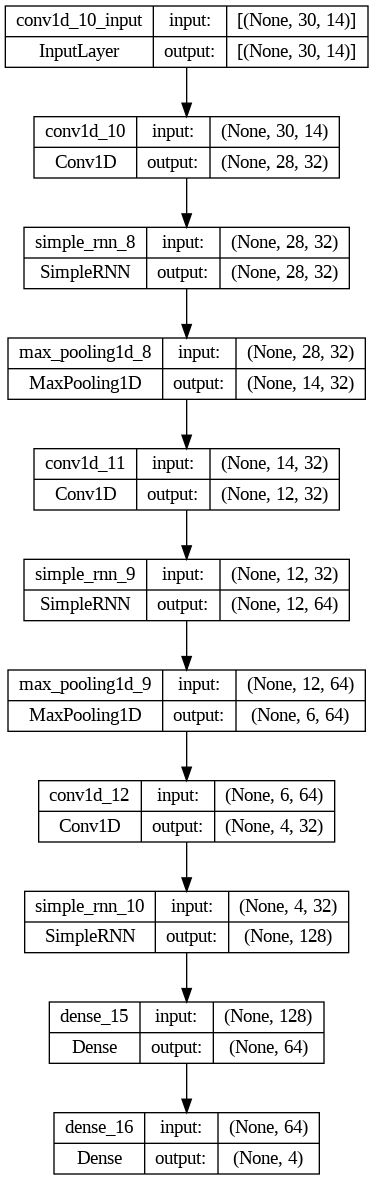

In [ ]:
model_name = "CNN-RNN"
from tensorflow.keras.utils import plot_model
for i in configs_nums:
    
    n_layers, d_model, head, epoch = combinations[i]
    niter = len(X_trn)
    losses, val_losses = [], []
    model = Sequential()
    model.add(Conv1D(d_model, kernel_size=3,activation='relu')),
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(MaxPooling1D(pool_size=2)),
    model.add(Conv1D(d_model, kernel_size=3, activation='relu')),
    model.add(SimpleRNN(64, return_sequences=True))
    model.add(MaxPooling1D(pool_size=2)),
    model.add(Conv1D(d_model, kernel_size=3, activation='relu')),
    model.add(SimpleRNN(128))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(units=4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    History = model.fit(X_trn, y_trn, epochs = epoch, batch_size=256, validation_split=0.2)
    y_pred = model.predict(X_tst)
    test_loss, test_acc = model.evaluate(X_tst, y_tst, verbose=2)
      # calculate precision and recall
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_tst_labels = np.argmax(y_tst, axis=1)
    precision = precision_score(y_tst_labels, y_pred_labels, average='macro')
    recall = recall_score(y_tst_labels, y_pred_labels, average='macro')
    conf_ls["{},{},{},{},{}".format(model_name, i, n_layers, d_model, epoch)] = (test_acc, precision, recall)
print(conf_ls)
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
